# 数理工学モデル化演習 第6回・第7回 課題
テキスト`20200602_textbook.ipynb`を読み、以下の演習を遂行せよ。

### 演習 
データ`access_log.csv`を利用し、次の数理モデルを実装せよ。

> - 【リスト】rcenの定義域のリスト  
> $R$  
> - 【リスト】freqの定義域のリスト  
> $F$  
> - 【定数】総件数  
> $N_{r,f} \ \ (r \in R, f \in F)$  
> - 【定数】再閲覧確率の実績値  
> $prob_{r,f} \ \ (r \in R, f \in F)$  
> - 【変数】rcen $r(\in R)$とfreq $f(\in F)$に対応する推定する再閲覧確率  
> $pred\_prob_{rf} \in [0, 1]\ \ (r \in R, f \in F)$  
> - pred_probはrcenについて単調減少  
> $pred\_prob_{r,f} \geq pred\_prob_{r+1,f}\ \ (r \in R, f \in F)$  
> - pred_probはfreqについて単調増加  
> $pred\_prob_{r,f} \leq pred\_prob_{r,f+1}\ \ (r \in R, f \in F)$  
> - pred_probはrcenについて凸  
> $pred\_prob_{r+1,f} - pred\_prob_{r,f} \leq pred\_prob_{r+2,f} - pred\_prob_{r+1,f}\ \ (r \in R, f \in F)$  
> - pred_probはfreqについて凹  
> $pred\_prob_{r,f+1} - pred\_prob_{r,f} \geq pred\_prob_{r,f+2} - pred\_prob_{r,f+1}\ \ (r \in R, f \in F)$  
> - 推定した再閲覧確率と再閲覧確率の実績値との乖離を総件数の重み付きで最小化する  
> $minimize\ \  \Sigma_{r \in R, f \in F} N_{r,f}\cdot(pred\_prob_{r,f}-prob_{r,f})^2$  

次の行にコードを実装し、最適化を実行せよ。また、もとめた$pred\_prob_{rf}$をテーブル形式で表示せよ。

In [1]:
import pandas as pd
import datetime
import numpy as np
from cvxopt import matrix
from cvxopt import solvers

#アクセスログの読み込み
log_dfm = pd.read_csv('access_log.csv', parse_dates=['date'])

#必要なデータの分離と抽出
start_date = datetime.datetime(2015,7,1)
end_date = datetime.datetime(2015,7,7)
target_date = datetime.datetime(2015,7,8)
x_dfm = log_dfm[(start_date <= log_dfm.date) & (log_dfm.date <= end_date)]
y_dfm = log_dfm[log_dfm.date == target_date]

#rcenとfreqとpv_flagを加味したデータを作成
U2I2Rcens = {}
for row in x_dfm.itertuples():
    rcen = (target_date - row.date).days
    U2I2Rcens.setdefault(row.user_id, {})
    U2I2Rcens[row.user_id].setdefault(row.item_id, [])
    U2I2Rcens[row.user_id][row.item_id].append(rcen)
    
Rows1 = []
for user_id, I2Rcens in U2I2Rcens.items():
    for item_id, Rcens in I2Rcens.items():
        freq = len(Rcens)
        rcen = min(Rcens)
        Rows1.append((user_id, item_id, rcen, freq))
UI2RF_dfm = pd.DataFrame(Rows1, columns=['user_id', 'item_id', 'rcen', 'freq'])

y_dfm = y_dfm[~y_dfm.duplicated()]
y_dfm['pv_flag'] = 1

UI2RFP_dfm = pd.merge(UI2RF_dfm, y_dfm[['user_id', 'item_id', 'pv_flag']], left_on=['user_id', 'item_id'], right_on=['user_id', 'item_id'], how='left')
UI2RFP_dfm.pv_flag.fillna(0, inplace=True)

#上記からprobを求める際に必要なデータを作成
tar_dfm = UI2RFP_dfm[UI2RFP_dfm.freq <= 7]

#クロス集計をし再閲覧確率probを求める
rcen_dfm = pd.crosstab(index=tar_dfm['rcen'], columns=tar_dfm['pv_flag'])
rcen_dfm.columns = ['neg', 'pos']
rcen_dfm['N'] = rcen_dfm.neg + rcen_dfm.pos
rcen_dfm['prob'] = rcen_dfm.pos / rcen_dfm.N

freq_dfm = pd.crosstab(index=tar_dfm['freq'], columns=tar_dfm['pv_flag'])
freq_dfm.columns = ['neg', 'pos']
freq_dfm['N'] = freq_dfm.neg + freq_dfm.pos
freq_dfm['prob'] = freq_dfm.pos / freq_dfm.N

#各辞書を作成して本データである　rf_dfm　を作る
RF2N = {}
RF2PV = {}
for row in tar_dfm.itertuples():
    RF2N.setdefault((row.rcen, row.freq), 0)
    RF2PV.setdefault((row.rcen, row.freq), 0)
    RF2N[row.rcen, row.freq] += 1
    if row.pv_flag == 1:
        RF2PV[row.rcen, row.freq] += 1
        
RF2Prob = {}
for rf, N in RF2N.items():
    RF2Prob[rf] = RF2PV[rf] / N

Rows3 = []
for rf, N in sorted(RF2N.items()):
    pv = RF2PV[rf]
    prob = RF2Prob[rf]
    row = (rf[0], rf[1], N, pv, prob)
    Rows3.append(row)
rf_dfm = pd.DataFrame(Rows3, columns = ['rcen', 'freq', 'N', 'pv', 'prob'])



#以下から数理モデルを実装する



#リストR,Fの定義
R = sorted(tar_dfm.rcen.unique().tolist())
F = sorted(tar_dfm.freq.unique().tolist())

#変数の定義
Idx = []
RF2Idx = {}
idx = 0
for r in R:
    for f in F:
        Idx.append(idx)
        RF2Idx[r, f] = idx 
        idx += 1

#制約式
G_list = []
h_list = []
var_vec = [0.0] * len(Idx)     

# - pred_prob[r,f] <= 0 のモデリング
for r in R:
    for f in F:
        idx = RF2Idx[r,f]
        G_row = var_vec[:]
        G_row[idx] = -1 # pred_prob[r,f]の係数は-1
        G_list.append(G_row)
        h_list.append(0) # 右辺は定数項0
        
# pred_prob[r,f] <= 1 のモデリング
for r in R:
    for f in F:
        idx = RF2Idx[r,f]
        G_row = var_vec[:]
        G_row[idx] = 1
        G_list.append(G_row[:])
        h_list.append(1)        
        
# - pred_prob[r,f] + pred_prob[r+1,f] <= 0 のモデリング
for r in R[:-1]:
    for f in F:
        idx1 = RF2Idx[r,f]
        idx2 = RF2Idx[r+1,f]
        G_row = var_vec[:]
        G_row[idx1] = -1 # pred_prob[r,f]の係数は-1
        G_row[idx2] = 1  # pred_prob[r+1,f]の係数は1
        G_list.append(G_row[:])
        h_list.append(0) # 右辺は定数項0
        
# pred_prob[r,f] - pred_prob[r,f+1] <= 0 のモデリング
for r in R:
    for f in F[:-1]:
        idx1 = RF2Idx[r,f]
        idx2 = RF2Idx[r,f+1]
        G_row = var_vec[:]
        G_row[idx1] = 1  # pred_prob[r,f]の係数は1
        G_row[idx2] = -1 # pred_prob[r,f+1]の係数は-1
        G_list.append(G_row[:])
        h_list.append(0) # 右辺は定数項0

# - pred_prob[r,f] + 2 * pred_prob[r+1,f] - pred_prob[r+2,f] <= 0 のモデリング
for r in R[:-2]:
    for f in F:
        idx1 = RF2Idx[r,f]
        idx2 = RF2Idx[r+1,f]
        idx3 = RF2Idx[r+2,f]
        G_row = var_vec[:]
        G_row[idx1] = -1 # pred_prob[r,f]の係数は-1
        G_row[idx2] = 2  # pred_prob[r+1,f]の係数は2
        G_row[idx3] = -1 # pred_prob[r+2,f]の係数は-1
        G_list.append(G_row[:])
        h_list.append(0) # 右辺は定数項0

# pred_prob[r,f] - 2 * pred_prob[r,f+1] + pred_prob[r,f+2] <= 0 のモデリング
for r in R:
    for f in F[:-2]:
        idx1 = RF2Idx[r,f]
        idx2 = RF2Idx[r,f+1]
        idx3 = RF2Idx[r,f+2]
        G_row = var_vec[:]
        G_row[idx1] = 1  # pred_prob[r,f]の係数は-1
        G_row[idx2] = -2 # pred_prob[r,f+1]の係数は2
        G_row[idx3] = 1  # pred_prob[r,f+2]の係数は-1
        G_list.append(G_row[:])
        h_list.append(0) # 右辺は定数項0      
        

#目的関数
P_list = []
q_list = []

# N[r,f] * pred_prob[r,f]^2 - 2 * N[r,f] * prob[r,f] のモデリング
for r in R:
    for f in F:
        idx = RF2Idx[r,f]
        N = RF2N[r,f]
        prob = RF2Prob[r,f]
        P_row = var_vec[:]
        P_row[idx] = 2 * N # (1/2)を打ち消すために2を掛ける
        P_list.append(P_row[:])
        ｑ_list.append( - 2 * N * prob)
        
G = matrix(np.array(G_list), tc='d')
h = matrix(np.array(h_list), tc='d')
P = matrix(np.array(P_list), tc='d')
q = matrix(np.array(q_list), tc='d')


#最適化計算
sol = solvers.qp(P, q, G, h)
status = sol['status']
status

     pcost       dcost       gap    pres   dres
 0: -5.2387e+01 -1.0684e+02  5e+02  2e+00  2e-02
 1: -5.2162e+01 -7.3611e+01  5e+01  2e-01  1e-03
 2: -5.1452e+01 -6.2961e+01  2e+01  4e-02  4e-04
 3: -5.1298e+01 -5.5766e+01  6e+00  1e-02  8e-05
 4: -5.1190e+01 -5.2365e+01  1e+00  1e-03  1e-05
 5: -5.1182e+01 -5.1589e+01  4e-01  1e-04  1e-06
 6: -5.1206e+01 -5.1382e+01  2e-01  5e-05  4e-07
 7: -5.1216e+01 -5.1298e+01  8e-02  6e-06  5e-08
 8: -5.1223e+01 -5.1241e+01  2e-02  1e-06  1e-08
 9: -5.1225e+01 -5.1228e+01  2e-03  2e-16  5e-16
10: -5.1226e+01 -5.1226e+01  7e-05  1e-16  3e-16
11: -5.1226e+01 -5.1226e+01  1e-06  2e-16  1e-15
Optimal solution found.


'optimal'

In [2]:
#求めた𝑝𝑟𝑒𝑑_𝑝𝑟𝑜𝑏𝑟𝑓をテーブル形式で表示する
RF2PredProb = {}
X = sol['x']
for r in R:
    for f in F:
        idx = RF2Idx[r,f]
        pred_prob = X[idx]
        RF2PredProb[r,f] = pred_prob
rf_dfm['pred_prob'] = rf_dfm.apply(lambda x:RF2PredProb[x.rcen, x.freq], axis=1)
rf_dfm.head()        
rf_dfm.pivot_table(index='rcen', columns='freq', values='pred_prob')

freq,1,2,3,4,5,6,7
rcen,,,,,,,
1,0.012499,0.039723,0.066240,0.087729,0.109218,0.130707,0.152197
2,0.006216,0.022573,0.038931,0.055288,0.069614,0.083939,0.083939
3,0.005700,0.019881,0.033408,0.044999,0.046786,0.048573,0.050349
4,0.005185,0.017188,0.027886,0.034709,0.034709,0.034709,0.034709
5,0.004670,0.014496,0.023566,0.024419,0.025272,0.026125,0.026978
6,0.004360,0.011803,0.019247,0.019247,0.019247,0.019247,0.019247
7,0.004222,0.009575,0.014927,0.017426,0.017426,0.017426,0.017426


一応視覚的に回答を確認するため、rcenとfreqに対するpred_probrfの3Dグラフを描画する

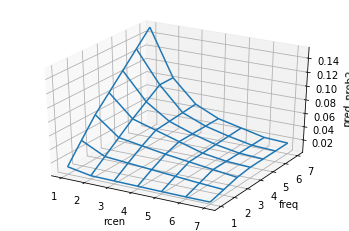

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

Freq = rf_dfm.freq.unique().tolist()
Rcen = rf_dfm.rcen.unique().tolist()
Z = [rf_dfm[(rf_dfm.freq==freq) & (rf_dfm.rcen==rcen)].pred_prob.iloc[0] for freq in Freq for rcen in Rcen]
Z = np.array(Z).reshape((len(Freq), len(Rcen)))
X, Y = np.meshgrid(Rcen, Freq)  
fig = plt.figure()
ax = fig.add_subplot(111
                     , projection="3d"
                     , xlabel='rcen'
                     , ylabel='freq'
                     , zlabel='pred_prob2'
                    )
ax.plot_wireframe(X, Y, Z)

3Dグラフが資料の最後のものと一致することが分かる

## 授業アンケート
以下に設問に回答してください。
1. 学籍番号と氏名を記入してください。
2. テキストを読むのにかかった時間をおしえてください。
3. 課題を遂行するのにかかった時間をおしえてください。
4. その他、お気づきの点がありましたらおしえてください。

## 回答

1．学籍番号と氏名:201811259 田畑尚哉
    
2．100分

3．120分

4． rcenはrecentryの略のrecenの誤字かと思いました。内容が非常に自分が気になっていたこと・興味のあることでした。

引き続きご鞭撻のほどよろしくお願い致します。